In [1]:
import sys, json
from itertools import groupby
sys.path.append(r"../")

from PIL import Image, ImageDraw
from pathlib import Path
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from detectron2.data import MetadataCatalog
import cameratransform as ct

import ct_assist as cta
from ct_assist import reference_detection as rd
from ct_assist import transform as ctf
from ct_assist.utils import accuracy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = r"../../dataset2"
anno_dir = data_dir + "/annotations"
im_dir = Path(r"D:\University\2020-2021\Internship\dataset2\images")


In [3]:
with open(r"D:\University\2020-2021\Internship\dataset2\annotations\simulation_properties.json") as f:
    sims = json.load(f)
sim = sims[0]  # Only one simulation filed
sim.keys()

dict_keys(['resolution_max', 'particle_number', 'particle_radius', 'particle_max', 'particle_min', 'particle_band_width', 'time_scale', 'use_adaptive_timesteps', 'flip_ratio', 'viscosity_base', 'viscosity_exponent', 'mesh_scale', 'mesh_particle_radius', 'mesh_concave_lower', 'mesh_concave_upper', 'mesh_smoothen_neg', 'mesh_smoothen_pos', 'cache_directory', 'cache_type', 'cache_frame_end', 'execution_time_data', 'successful_simulation_data', 'execution_time_mesh', 'successful_simulation_mesh', 'fluid_volume_cm3_per_frame', 'area_cm2_per_frame', 'domain_longest_side', 'domain_volume', 'id'])

In [4]:
with open(r"D:\University\2020-2021\Internship\dataset2\annotations\images.json") as f:
    imgs = json.load(f)

In [5]:
def load():
    with open(anno_dir + "/images.json") as f:
        img_lst = json.load(f)

    with open(anno_dir + "/instance_segmentation.json") as f:
        anno_lst = sorted(json.load(f), key=lambda x: x["image_id"])

    predictor, cfg = rd.load_model(return_cfg=True)

    X = []
    Y_test = []
    X_area = []
    X_cprops = []
    Y_area = []

    classes = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes")
    a = 0
    for k, g in groupby(tqdm(anno_lst), lambda x: x["image_id"]):
        a += 1
        record = {"height":1080, "width":1920}
        record["image_id"] = k
        record["file_name"] = im_dir / img_lst[k].get("file_name")
        img = Image.open(record["file_name"])
        arr = np.asarray(img)[...,:3]

        pred = predictor(arr)
        inst_dict = rd.instances_to_dict(pred, classes)

        ref = rd.extract_reference(inst_dict, always_warn=False)
        if len(ref) == 0:
            continue
        if len(ref[0][0]) == 0:
            continue
        X.append({"img": img, "reference": [], "height": [], "STD": [], "meta_data": {"focal_length": 50, "image_size": (1920, 1080), "sensor_size": (36, 24)}, "multi": True})
        Y_test.append([img_lst[k].get(key) for key in ["roll_deg", "tilt_deg", "heading_deg", "elevation"]])
        for r, h, s in ref:
            X[-1]["reference"].append(r)
            X[-1]["height"].append(h)
            X[-1]["STD"].append(s)

        sim_id = img_lst[k].get("simulation_id")
        if sim_id == 0.0:
            segs = None
            for anno in filter(lambda x: x["category_id"] == 0, g):                
                segs = anno["segmentation"]

            if segs:
                frame = img_lst[k].get("frame")
                X_area.append(X[-1].copy())
                X_area[-1]["image_coords"] = [np.array(list(zip(a[::2], a[1::2]))) for a in segs]
                Y_area.append(sim["area_cm2_per_frame"][k] / 10_000) 
                X_cprops.append((Y_test[-1], X[-1]["meta_data"], X_area[-1]["image_coords"]))
    
    return X, Y_test, X_area, X_cprops, Y_area

X, Y_test, X_area, X_cprops, Y_area = load()

  0%|                                                                                         | 0/2289 [00:00<?, ?it/s]C:\Users\Caspe\Anaconda3\envs\ct_assist\lib\site-packages\detectron2\modeling\roi_heads\fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()
  3%|██                                                                              | 58/2289 [00:03<35:30,  1.05it/s]C:\Users\Caspe\Anaconda3\envs\ct_assist\lib\site-packages\ct_assist\reference_detection.py:175: SkipFieldWarning: Key `handbag` not found in `height_dict`. Skipped this field.
  f"Key `{key}` not found in `height_dict`. Skipped this field.", SkipFieldWarning)
  3%|██▌                                                                             | 73/2289 [00:05<18:52,  1.96it/s]C:\Users\Caspe\Ana

In [6]:
X_c = X.copy()
Y_c = Y_test.copy()

In [7]:
# Test area with known camera properties
def make_cam(roll_deg, tilt_deg, heading_deg, elevation, focal_length, image_size, sensor_size, img_cords):

    proj = ct.RectilinearProjection(focallength_mm=focal_length,
                                         sensor=sensor_size,
                                         image=image_size)
    # initialize the camera
    cam = ct.Camera(proj, ct.SpatialOrientation(elevation_m=elevation,
                                          tilt_deg=tilt_deg,
                                          heading_deg=heading_deg,
                                          roll_deg=roll_deg
                                          ))
    
    
    points = (cam.spaceFromImage(points=x) for x in img_cords)
    areas = sum(accuracy.calc_area(poly[:, :2]) for poly in points)
    return areas
areas = [make_cam(*ext, **inte, img_cords=im) for ext, inte, im in tqdm(X_cprops)]
print(areas)
mean_squared_error(Y_area, areas)

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 198.56it/s]

[78.70871646654064, 0, 141.97966190951274, 0, 0, 161.6398109148722, 118.79435457602585, 0, 0, 889.7805799458747, 0, 26544.48360568831, 28026.640641516155, 0, 130.68313496849026, 0, 7313.865205160753, 576.46152197913, 2537.8472457677267, 27272.846923005236, 0, 0, 0, 0, 0, 0, 99908.62708667273, 4391.3612994596015, 14990.036244378512, 5559.278723739861, 57.53768663982038, 780.9280125814839, 1117025.6463087457, 15739.527725523361, 2498419.9998002904, 0, 36666.37302108177, 63397.52712436802, 7653.650524870101, 2405.2754238326893, 1840.772822600873, 481133.9715058399, 0, 8600.96093696795, 0, 331.8774331073171, 3675.916258036088, 0, 0, 0, 0, 0, 0, 8.625964885261396, 4693.557066892891]


140710877443.95895

In [8]:
score2, pred_area = accuracy.area(X_area, Y_area)
score2

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [07:46<00:00,  8.48s/it]


5995.301120659949

In [9]:
score, ypred, ytue = accuracy.camera_properties(X_c, Y_c)

100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [21:02<00:00,  8.20s/it]


In [10]:
score

(38.832077090454504, 23.82268946191942, 188.95660931327612, 33.50345214601181)

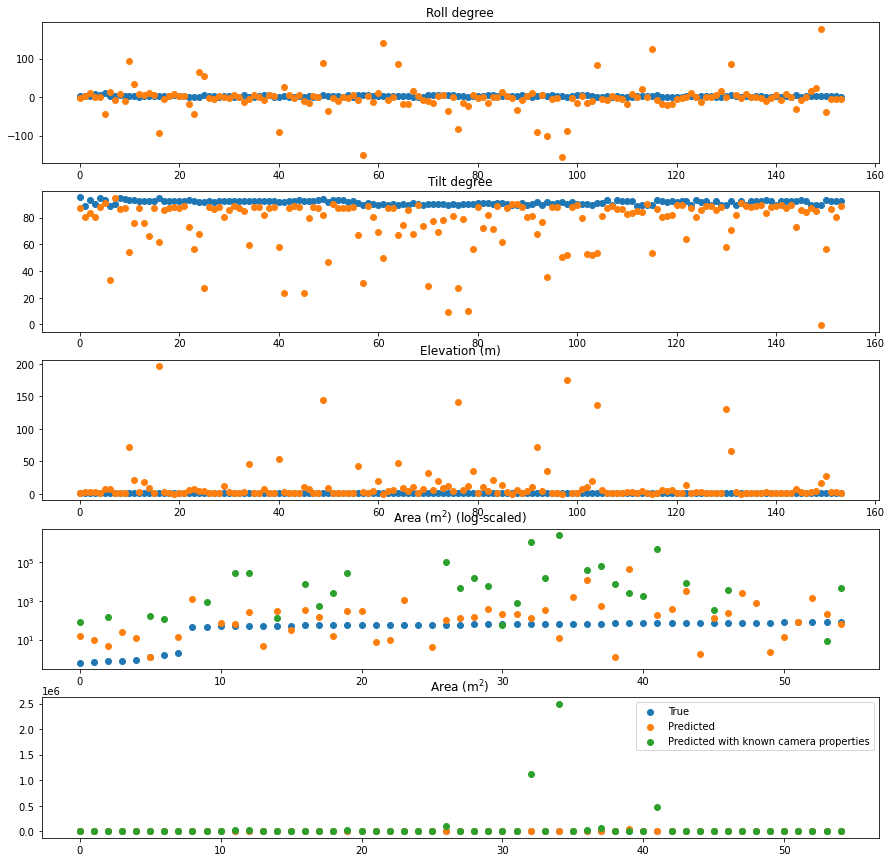

In [11]:
fig, ax = plt.subplots(5, figsize=(15, 15))

# for i in [0, 1, 3]:
# ax[0].plot(ypred[...,0], label="pred")
# ax[0].plot(ytue[..., 0], label="true")

ax[0].scatter(range(ytue.shape[0]), ytue[..., 0], label="True")
ax[0].scatter(range(ytue.shape[0]), ypred[...,0], label="Predicted")
ax[0].set_title("Roll degree")


# ax[1].plot(ypred[...,1], label="pred")
# ax[1].plot(ytue[..., 1], label="true")
ax[1].scatter(range(ytue.shape[0]), ytue[..., 1], label="True")
ax[1].scatter(range(ytue.shape[0]), ypred[...,1], label="Predicted")
ax[1].set_title("Tilt degree")

# ax[2].plot(ypred[...,3], label="pred")
# ax[2].plot(ytue[..., 3], label="true")
ax[2].scatter(range(ytue.shape[0]), ytue[..., 3], label="True")
ax[2].scatter(range(ytue.shape[0]), ypred[...,3], label="Predicted")
ax[2].set_title("Elevation (m)")

ax[3].set_yscale('log')
ax[3].scatter(range(len(X_area)), Y_area, label="True")
ax[3].scatter(range(len(X_area)), pred_area, label="Predicted")
ax[3].scatter(range(len(X_area)), areas, label="Predicted with known camera properties")
ax[3].set_title("Area (m$^{2}$) (log-scaled)")


# ax[3].set_yscale('log')
ax[4].scatter(range(len(X_area)), Y_area, label="True")
ax[4].scatter(range(len(X_area)), pred_area, label="Predicted")
ax[4].scatter(range(len(X_area)), areas, label="Predicted with known camera properties")
ax[4].set_title("Area (m$^{2}$)")



plt.legend()
plt.show()
    